In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [16]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
velGmagDF.head()

normMLT  MLAT    vSaps   azim  vMagnErr  azimErr     dtStr  tmStr  \
0       -4  60.5   634.32 -10.10      7.19    21.54  20130316    500   
1       -3  60.5   659.19 -14.60      7.18    18.52  20130316    500   
2       -2  60.5   659.19 -14.60      7.18    18.52  20130316    500   
3       -4  61.0  1202.45 -15.47      6.97    12.20  20130316    500   
4       -3  61.0   799.26 -13.31      8.43    17.93  20130316    500   

                  date  hour             dst_date  dst_index     dst_bin   AE  \
0  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
1  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
2  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
3  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
4  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   

    AL   AO   AU  minute  
0 -575 -210  156       0  
1 -575 -210  156       0  
2 -575 -210  156       0  
3 -575 -210  156       0  
4 -575 -210  156       0

In [17]:
# Create AE bins
aeBins = [ 0, 250, 500, 1000, 1500, 2100 ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["AE"], \
                               bins=aeBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps", "azim",\
                         "vMagnErr", "azimErr", "dtStr", "tmStr",\
                         "date", "hour", "dst_date",\
                         "dst_index", "dst_bin", \
                         "AE", "AL", "AO", "AU", "minute", "AE_bin"]
velGmagDF.head()

normMLT  MLAT    vSaps   azim  vMagnErr  azimErr     dtStr  tmStr  \
0       -4  60.5   634.32 -10.10      7.19    21.54  20130316    500   
1       -3  60.5   659.19 -14.60      7.18    18.52  20130316    500   
2       -2  60.5   659.19 -14.60      7.18    18.52  20130316    500   
3       -4  61.0  1202.45 -15.47      6.97    12.20  20130316    500   
4       -3  61.0   799.26 -13.31      8.43    17.93  20130316    500   

                  date  hour             dst_date  dst_index     dst_bin   AE  \
0  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
1  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
2  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
3  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   
4  2013-03-16 05:00:00     5  2013-03-16 05:00:00        -19  (-25, -10]  731   

    AL   AO   AU  minute       AE_bin  
0 -575 -210  156       0  (500, 1000]  
1 -575 -210  156       0  (500, 1000]  
2 -575 -210  156       0  (500, 1000]  
3 -575 -210  156       0  (500, 1000]  
4 -575 -210  156       0  (500, 1000]

In [57]:
# Groupby Dst bin
aeLocDF = velGmagDF.groupby( [ "AE_bin", "normMLT", "MLAT" ] ).mean().reset_index()
aeLocDF = aeLocDF.dropna().reset_index(drop=True)
aeLocDF.head()

AE_bin  normMLT  MLAT    vSaps   azim  vMagnErr  azimErr     dtStr  \
0  (0, 250]       -8  58.0  253.190 -17.40     4.030     7.02  20120123   
1  (0, 250]       -8  58.5  480.980 -17.40     4.030     7.02  20120123   
2  (0, 250]       -8  59.0  480.980 -17.40     4.030     7.02  20120123   
3  (0, 250]       -8  59.5  641.480 -19.89     1.910     2.48  20120123   
4  (0, 250]       -8  60.0  556.605 -14.12     3.915     9.38  20115525   

   tmStr  hour  dst_index   AE    AL  AO     AU  minute  
0    122     1      -63.0  204 -84.0  18  120.0      22  
1    122     1      -63.0  204 -84.0  18  120.0      22  
2    122     1      -63.0  204 -84.0  18  120.0      22  
3    122     1      -63.0  204 -84.0  18  120.0      22  
4    133     1      -82.5  223 -93.5  18  129.5      33

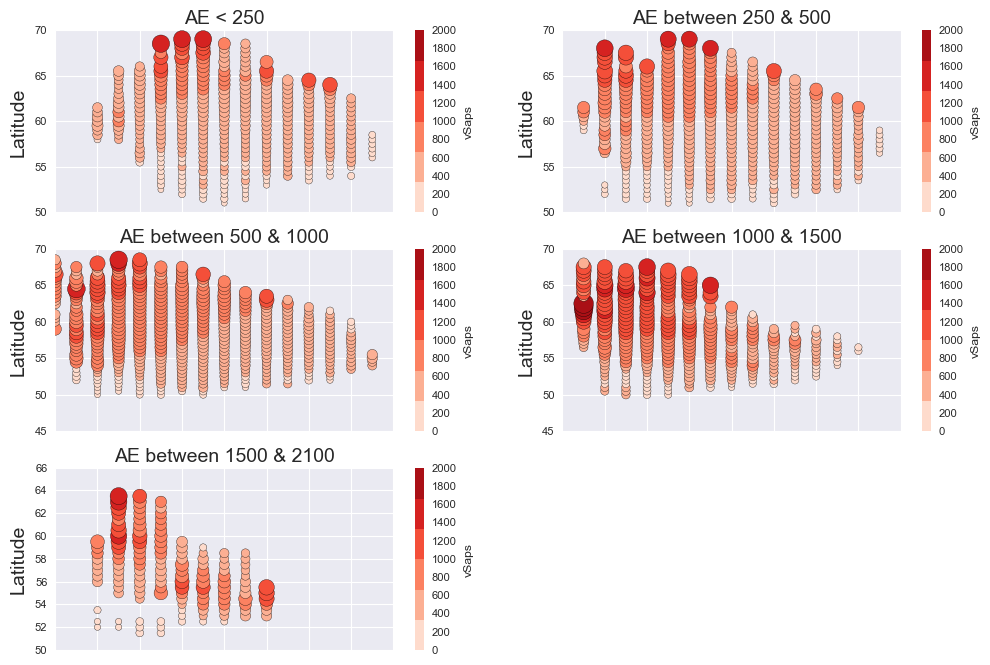

In [64]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (0,250]
aeSapsMLTLat250 = aeLocDF[ aeLocDF["AE_bin"] == "(0, 250]" ]
aeSapsMLTLat250.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat250["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "AE < 250", fontsize=14 )
ax1.set_xlim([-10., 6.])
# (250,500]
aeSapsMLTLat500 = aeLocDF[ aeLocDF["AE_bin"] == "(250, 500]" ]
aeSapsMLTLat500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "AE between 250 & 500", fontsize=14 )
ax2.set_xlim([-10., 6.])
# (500,1000]
aeSapsMLTLat1000 = aeLocDF[ aeLocDF["AE_bin"] == "(500, 1000]" ]
aeSapsMLTLat1000.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1000["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "AE between 500 & 1000", fontsize=14 )
ax3.set_xlim([-10., 6.])
# (1000,1500]
aeSapsMLTLat1500 = aeLocDF[ aeLocDF["AE_bin"] == "(1000, 1500]" ]
aeSapsMLTLat1500.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat1500["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "AE between 1000 & 1500", fontsize=14 )
ax4.set_xlim([-10., 6.])
# (1500,2100]
aeSapsMLTLat2100 = aeLocDF[ aeLocDF["AE_bin"] == "(1500, 2100]" ]
aeSapsMLTLat2100.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=aeSapsMLTLat2100["vSaps"]/10, cmap=seaMap, vmin=0, vmax=2000, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "AE between 1500 & 2100", fontsize=14 )
ax5.set_xlim([-10., 6.])

plt.savefig("../figs/allAEBinsVels.pdf",bbox_inches='tight')

In [65]:
### Group by ae and dst bins together

normMLT  MLAT   vSaps   azim  vMagnErr  azimErr     dtStr  tmStr  \
688          -2  57.5  274.13  -6.26      0.73     6.28  20130316    618   
689          -1  57.5  274.13  -6.26      0.73     6.28  20130316    618   
690          -2  58.0  274.13  -6.26      0.73     6.28  20130316    618   
691          -1  58.0  274.13  -6.26      0.73     6.28  20130316    618   
692          -2  58.5  269.37  -6.78      1.38     9.37  20130316    618   
693          -1  58.5  248.88 -10.15      4.70    26.72  20130316    618   
694          -2  59.0  273.80  -7.49      2.30    14.10  20130316    618   
695          -1  59.0  529.92 -17.16      5.80    18.19  20130316    618   
696           0  59.0  506.47 -18.01      2.24     5.11  20130316    618   
697           1  59.0  506.47 -18.01      2.24     5.11  20130316    618   
698           2  59.0  429.81 -16.26      9.20    20.60  20130316    618   
699          -2  59.5  328.80 -15.24      7.94    24.55  20130316    618   
700          -1  59.5  539.20 -14.95      4.12    15.42  20130316    618   
701           0  59.5  506.47 -18.01      2.24     5.11  20130316    618   
702           1  59.5  506.47 -18.01      2.24     5.11  20130316    618   
703           2  59.5  444.99 -16.66      6.50    13.87  20130316    618   
704          -2  60.0  510.28 -13.94      4.83    15.19  20130316    618   
705          -1  60.0  510.28 -13.94      4.83    15.19  20130316    618   
706           0  60.0  521.97 -15.48      2.29     6.11  20130316    618   
707           1  60.0  521.97 -15.48      2.29     6.11  20130316    618   
708           2  60.0  426.38 -18.54      7.87    14.32  20130316    618   
709          -2  60.5  582.42 -17.65      2.81     6.82  20130316    618   
710          -1  60.5  582.42 -17.65      2.81     6.82  20130316    618   
711           0  60.5  499.32 -13.93      4.68    13.64  20130316    618   
712           1  60.5  499.32 -13.93      4.68    13.64  20130316    618   
713          -2  61.0  598.83 -18.47      2.18     5.00  20130316    618   
714          -1  61.0  598.83 -18.47      2.18     5.00  20130316    618   
715           0  61.0  531.86 -13.20      4.70    14.96  20130316    618   
716          -2  56.5  325.65  -7.68      0.97     7.85  20130316    618   
717          -2  57.0  404.79  -7.68      0.97     7.85  20130316    618   
...         ...   ...     ...    ...       ...      ...       ...    ...   
333743        4  55.0  299.67  -7.75      1.78    19.31  20120523    828   
333744        0  55.5  405.99 -14.91      4.36    25.40  20120523    828   
333745        0  56.0  393.99 -18.30      3.24    15.11  20120523    828   
333746        0  56.5  419.66 -19.73      2.92    11.68  20120523    828   
333747        3  56.5  305.79  -8.86      1.99    17.54  20120523    828   
333748        0  57.0  415.95 -19.73      2.92    11.68  20120523    828   
333749        0  57.5  424.61 -19.73      2.92    11.68  20120523    828   
333750        1  57.5  461.92 -19.73      2.92    11.68  20120523    828   
333751        1  58.0  508.49 -17.77      3.93    15.53  20120523    828   
333752        3  54.0  228.62  -8.92      1.14    13.27  20120523    830   
333753        2  54.5  297.19   8.19      3.00    23.13  20120523    830   
333754        3  54.5  238.25  -8.10      1.11    12.63  20120523    830   
333755        1  55.0  275.58 -10.05      3.07    32.37  20120523    830   
333756        2  55.0  297.19   8.19      3.00    23.13  20120523    830   
333757        3  55.0  246.92  -9.75      1.05     9.22  20120523    830   
333758        1  55.5  286.38 -11.08      2.92    24.04  20120523    830   
333759        2  55.5  286.38 -11.08      2.92    24.04  20120523    830   
333760        3  55.5  246.92  -9.75      1.05     9.22  20120523    830   
333761        1  56.0  310.26 -15.91      3.40    16.62  20120523    830   
333762        2  56.0  310.26 -15.91      3.40    16.62  20120523    830   
333763        3  56.0  259.42 -10.84      1.37    10.26 